In [1]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split
import pandas as pd

C:\Users\Eirik\anaconda3\envs\raskmonai\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [2]:
path = Path('..\data')
path.mkdir(exist_ok=True)

In [3]:
ProstateSet = DecathlonDataset(root_dir=path, task="Task05_Prostate", section="training", download=False,
                                 cache_num=0, num_workers=3)

In [4]:
df = pd.DataFrame(ProstateSet.data)


In [5]:
df.head()

,image,label
0,..\data\Task05_Prostate\imagesTr\prostate_46.nii.gz,..\data\Task05_Prostate\labelsTr\prostate_46.nii.gz
1,..\data\Task05_Prostate\imagesTr\prostate_01.nii.gz,..\data\Task05_Prostate\labelsTr\prostate_01.nii.gz
2,..\data\Task05_Prostate\imagesTr\prostate_40.nii.gz,..\data\Task05_Prostate\labelsTr\prostate_40.nii.gz
3,..\data\Task05_Prostate\imagesTr\prostate_24.nii.gz,..\data\Task05_Prostate\labelsTr\prostate_24.nii.gz
4,..\data\Task05_Prostate\imagesTr\prostate_44.nii.gz,..\data\Task05_Prostate\labelsTr\prostate_44.nii.gz


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   26 non-null     object
 1   label   26 non-null     object
dtypes: object(2)
memory usage: 544.0+ bytes


In [7]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((23, 2), (3, 2))

In [8]:
med_dataset = MedDataset(img_list=train_df.label.tolist()[:20], dtype=MedMask, max_workers=12)

In [9]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1,voxel_count_2
0,..\data\Task05_Prostate\labelsTr\prostate_28.nii.gz,384,384,11,0.6042,0.6042,4.0,RAS+,1589653,14398,17965.0
1,..\data\Task05_Prostate\labelsTr\prostate_04.nii.gz,320,320,15,0.6000,0.6000,4.0,RAS+,1460345,10847,64808.0
2,..\data\Task05_Prostate\labelsTr\prostate_39.nii.gz,320,320,15,0.6000,0.6000,4.0,RAS+,1495833,5229,34938.0
3,..\data\Task05_Prostate\labelsTr\prostate_06.nii.gz,320,320,20,0.6250,0.6250,3.6,RAS+,2004713,10730,32557.0
4,..\data\Task05_Prostate\labelsTr\prostate_01.nii.gz,320,320,20,0.6250,0.6250,3.6,RAS+,1997347,12273,38380.0


In [10]:
summary_df = med_dataset.summary()

In [11]:
summary_df

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
4,320,320,20,0.6250,0.6250,3.6,RAS+,..\data\Task05_Prostate\labelsTr\prostate_01.nii.gz,12
3,320,320,15,0.6000,0.6000,4.0,RAS+,..\data\Task05_Prostate\labelsTr\prostate_04.nii.gz,3
0,256,256,15,0.7500,0.7500,4.0,RAS+,..\data\Task05_Prostate\labelsTr\prostate_37.nii.gz,1
1,256,256,18,0.7500,0.7500,3.0,RAS+,..\data\Task05_Prostate\labelsTr\prostate_41.nii.gz,1
2,256,256,18,0.7500,0.7500,4.0,RAS+,..\data\Task05_Prostate\labelsTr\prostate_18.nii.gz,1
5,320,320,24,0.6250,0.6250,3.6,RAS+,..\data\Task05_Prostate\labelsTr\prostate_02.nii.gz,1
6,384,384,11,0.6042,0.6042,4.0,RAS+,..\data\Task05_Prostate\labelsTr\prostate_28.nii.gz,1


In [12]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([0.625, 0.625, 3.6], False)

In [13]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[371.0, 371.0, 24.0]

In [14]:
item_tfms = [ZNormalization(), PadOrCrop([368,368,32], padding_mode=3), RandomAffine(scales=0, degrees=5, isotropic=True)] 

In [15]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      batch_tfms=None,
                      reorder=reorder,
                      resample=resample)

In [16]:
bs=2
dls = dblock.dataloaders(train_df, bs=bs)

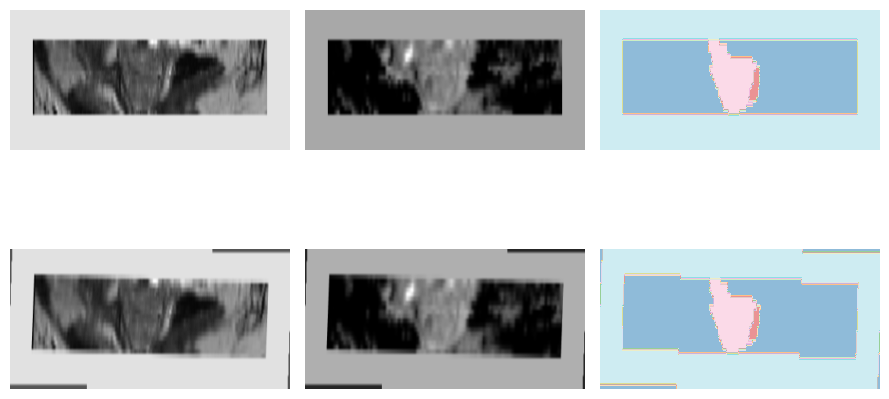

In [17]:
dls.show_batch(anatomical_plane=0, unique=True)

In [18]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(19, 4)

In [19]:
from monai.networks.nets import UNet
from monai.losses import DiceCELoss

In [20]:
codes = np.unique(med_img_reader(train_df.label.tolist()[0]))
n_classes = len(codes)

In [21]:
codes, n_classes

(array([0., 1., 2.], dtype=float32), 3)

In [22]:
model = UNet(dimensions=3, in_channels=2, out_channels=n_classes, 
             channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), 
             num_res_units=2)

C:\Users\Eirik\anaconda3\envs\raskmonai\lib\site-packages\monai\utils\deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)


In [23]:
loss_func = CustomLoss(loss_func=DiceCELoss(to_onehot_y=True, include_background=True, softmax=True))

In [24]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=multi_dice_score)

In [25]:
lr = learn.lr_find()#.to_fp16()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [198]:
epochs = 4

In [ ]:
learn.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,1.848183,1.752900,"tensor([0.0844, 0.2052])",00:14
1,1.748823,1.638796,"tensor([0.0779, 0.3025])",00:15
2,1.656571,1.472020,"tensor([0.0944, 0.4111])",00:17


In [ ]:
learn.save('baseline.prostate-model')

In [ ]:
learn.show_results(anatomical_plane=0, ds_idx=1)

In [ ]:
test_dl = learn.dls.test_dl(test_df,with_labels=True)

In [ ]:
test_dl.show_batch(anatomical_plane=0, figsize=(15,15))

In [ ]:
pred_acts, labels = learn.get_preds(dl=test_dl)
pred_acts.shape, labels.shape

In [ ]:
multi_dice_score(pred_acts, labels)

In [ ]:
learn.show_results(anatomical_plane=0, dl=test_dl, ds_idx=19)

In [57]:
learn.export('baseline_prostate_model.pkl')